In [37]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import time
from math import log10, floor
import os
import glob
import json
import matplotlib.pyplot as plt
import itertools
import datetime
from math import ceil, isnan
from params import *
import sys
import seaborn as sns
try:
    import torchtext
    from torchtext.data import Field, Iterator, Dataset, Example
except ImportError: 
    !{'/opt/anaconda3/bin/python3'} -m pip install --upgrade git+https://github.com/pytorch/text
    import torchtext
    from torchtext.data import Field, Iterator, Dataset, Example
try:
    import catheat
except ImportError: 
    !{'/opt/anaconda3/bin/python3'} -m pip install git+git://github.com/schlegelp/catheat@master
    import catheat
try:
    from bayes_opt import BayesianOptimization
except ImportError:
    !{'/opt/anaconda3/bin/python3'} -m pip install bayesian-optimization
    from bayes_opt import BayesianOptimization
try:
    from lifelines import CoxPHFitter
except ImportError:
    !{'/opt/anaconda3/bin/python3'} -m pip install lifelines
    from lifelines import CoxPHFitter

from relational_rnn_models import RelationalMemoryGenerator
from discriminator import RelGANDiscriminator

cuda = torch.cuda.is_available()

# Try setting the device to a GPU
device = torch.device("cuda:0" if cuda else "cpu")
print('Device:', device)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Device: cuda:0


In [2]:
# Helper function(s)

# round a number to n significant digits
def round_to_n(x, n = 2):
    return round(x, -int(floor(log10(abs(x)))) + (n - 1)) if x != 0 else 0

# Transform a date string into a datetime object
def str_to_datetime(string):
    return datetime.datetime.strptime(string, '%Y-%m-%d %H:%M:%S')

# TODO: more complex reduction: takes into account different ICD groups?
def reduce_icd(icd_full):
    return icd_full[:2]

def get_distribution(data, field, vocab_size, fake = True):
    counts = torch.zeros(vocab_size - 2)

    for i in range(2, vocab_size):
        if fake:
            counts[i - 2] = torch.sum(data == i)
        else:
            counts[i - 2] = field.vocab.freqs[field.vocab.itos[i]]

    freqs = counts / torch.sum(counts)
    
    return counts, freqs
    

In [3]:
%%time

filename = 'data/FINNGEN_ENDPOINTS_DF3_longitudinal_V1_for_SandBox.txt.gz'

endpoints = ['I9_HYPTENS', 'I9_ANGINA', 'I9_HEARTFAIL_NS', 'I9_STR_EXH', 'I9_CHD', 'C3_BREAST']

events = pd.read_csv(filename, compression = 'infer', sep='\t', nrows = 3_000_000)

subjects = events['FINNGENID'].unique()
n_individuals = len(subjects)
print(n_individuals)

print(events.columns)

# include all endpoints in a list
#events = events[events['ENDPOINT'].isin(endpoints)]
#events = events.groupby('FINNGENID').filter(lambda x: len(x) > 1)
events = events[events['EVENT_YEAR'] >= 2000]

print(len(events))

filename = 'data/FINNGEN_MINIMUM_DATA_R3_V1.txt'

patients = pd.read_csv(filename, compression = 'infer', sep='\t')
events = pd.merge(events, patients[['FINNGENID', 'SEX']])
events.columns

print(len(events))

subjects = events['FINNGENID'].unique()
n_individuals = len(subjects)
print(n_individuals)
print(events['ENDPOINT'].unique())

3123
Index(['FINNGENID', 'EVENT_AGE', 'EVENT_YEAR', 'ENDPOINT'], dtype='object')
2666554
2666554
3099
['ANY_ATC' 'XIII_MUSCULOSKELET' 'M13_MUSCULOSKELETAL' ...
 'H7_ORBITINFLAMCHRON' 'D3_WHITEBLOODCELLNAS' 'G6_DISOTHUNS']
CPU times: user 3.41 s, sys: 380 ms, total: 3.79 s
Wall time: 3.36 s


In [4]:
def get_sequence_of_codes(subject):
    codes = ['None' for _ in range(2017 - 2000 + 1)]
    
    years = subject.groupby('EVENT_YEAR')
    
    for g, year in years:
        value = 'None'
        if year['ENDPOINT'].isin(['C3_BREAST']).any():
            value = 'C3_BREAST'
        elif year['ENDPOINT'].isin(['I9_CHD']).any():
            value = 'I9_CHD'
        else:
            tmp = year['ENDPOINT'].unique()
            li = pd.Series(tmp).isin(endpoints)
            possible_endpoints = tmp[li]
            if len(possible_endpoints) > 0:
                value = np.random.choice(possible_endpoints)
        codes[g - 2000] = value
        
    res = ' '.join(codes)
    return res

def get_age(subject):
    event = subject.sort_values('EVENT_AGE').iloc[0]
    
    age = event['EVENT_AGE'] + 2000 - event['EVENT_YEAR']
        
    return age

#for g, subject in events.groupby('FINNGENID'):
#    print(get_sequence_of_codes(subject))
    


In [6]:
%%time

sequences_of_codes = events.groupby('FINNGENID').apply(get_sequence_of_codes)
#print(sequences_of_codes.head())
print(sequences_of_codes.apply(lambda x: len(x.split(' '))).describe())
print(sequences_of_codes.shape)

ages = events.groupby('FINNGENID').apply(get_age)
print(ages.shape)

sexes = events.groupby('FINNGENID')['SEX'].first()
sexes.shape

count    3099.0
mean       18.0
std         0.0
min        18.0
25%        18.0
50%        18.0
75%        18.0
max        18.0
dtype: float64
(3099,)
(3099,)
CPU times: user 1min 14s, sys: 164 ms, total: 1min 14s
Wall time: 1min 14s


(3099,)

In [7]:
#sequences = pd.DataFrame({'ENDPOINTS': sequences_of_codes.stack(), 'TIME_DIFFS': sequences_of_times.stack()})
sequences = pd.DataFrame({'ENDPOINT': sequences_of_codes, 'AGE': ages, 'SEX': sexes})
print(sequences.shape)
#sequences.head()


(3099, 3)


In [8]:
# https://stackoverflow.com/questions/52602071/dataframe-as-datasource-in-torchtext

class DataFrameDataset(Dataset):
    """Class for using pandas DataFrames as a datasource"""
    def __init__(self, examples, fields, filter_pred=None):
        """
        Create a dataset from a pandas dataframe of examples and Fields
        Arguments:
            examples pd.DataFrame: DataFrame of examples
            fields {str: Field}: The Fields to use in this tuple. The
                string is a field name, and the Field is the associated field.
            filter_pred (callable or None): use only exanples for which
                filter_pred(example) is true, or use all examples if None.
                Default is None
        """
        self.fields = dict(fields)
        self.examples = examples.apply(SeriesExample.fromSeries, args=(self.fields,), axis=1).tolist()
        if filter_pred is not None:
            self.examples = filter(filter_pred, self.examples)
        # Unpack field tuples
        for n, f in list(self.fields.items()):
            if isinstance(n, tuple):
                self.fields.update(zip(n, f))
                del self.fields[n]

class SeriesExample(Example):
    """Class to convert a pandas Series to an Example"""
    
    @classmethod
    def fromSeries(cls, data, fields):
        return cls.fromdict(data.to_dict(), fields)

    @classmethod
    def fromdict(cls, data, fields):
        ex = cls()
        for key, field in fields.items():
            if key not in data:
                raise ValueError("Specified key {} was not found in "
                "the input data".format(key))
            if field is not None:
                setattr(ex, key, field.preprocess(data[key]))
            else:
                setattr(ex, key, data[key])
        return ex

In [9]:
%%time

tokenize = lambda x: x.split(' ')

ENDPOINT = Field(tokenize = tokenize)
AGE = Field(sequential = False, use_vocab = False)
SEX = Field()

fields = [('ENDPOINT', ENDPOINT), ('AGE', AGE), ('SEX', SEX)]

train_sequences, val_sequences = train_test_split(sequences, test_size = 0.1)
print(train_sequences.shape, val_sequences.shape)

train = DataFrameDataset(train_sequences, fields)
val = DataFrameDataset(val_sequences, fields)
#print(val.examples[0].__dict__)

ENDPOINT.build_vocab(train, val)
SEX.build_vocab(train, val)

(2789, 3) (310, 3)
CPU times: user 124 ms, sys: 12 ms, total: 136 ms
Wall time: 137 ms


In [10]:
print(ENDPOINT.vocab.stoi['None'])
print(ENDPOINT.vocab.itos[2])
vocab_size = len(ENDPOINT.vocab.freqs) + 2
print(vocab_size)

print(ENDPOINT.vocab.freqs)

print(ENDPOINT.vocab.itos)

print(SEX.vocab.stoi['male'])
print(SEX.vocab.stoi['female'])
print(SEX.vocab.freqs)


2
None
9
Counter({'None': 52061, 'I9_HEARTFAIL_NS': 1763, 'I9_HYPTENS': 1183, 'I9_CHD': 359, 'I9_ANGINA': 211, 'I9_STR_EXH': 125, 'C3_BREAST': 80})
['<unk>', '<pad>', 'None', 'I9_HEARTFAIL_NS', 'I9_HYPTENS', 'I9_CHD', 'I9_ANGINA', 'I9_STR_EXH', 'C3_BREAST']
3
2
Counter({'female': 1743, 'male': 1356})


In [11]:
val_iter = Iterator(val, batch_size = len(val_sequences), repeat = True)

print(next(iter(val_iter)).ENDPOINT.transpose(0, 1).shape)
print(next(iter(val_iter)).AGE.shape)
print(next(iter(val_iter)).SEX.view(-1).shape)

torch.Size([310, 18])
torch.Size([310])
torch.Size([310])


torch.Size([310])


(array([ 2.,  9., 21., 25., 43., 56., 67., 61., 17.,  9.]),
 array([-12. ,  -2.9,   6.2,  15.3,  24.4,  33.5,  42.6,  51.7,  60.8,
         69.9,  79. ]),
 <a list of 10 Patch objects>)

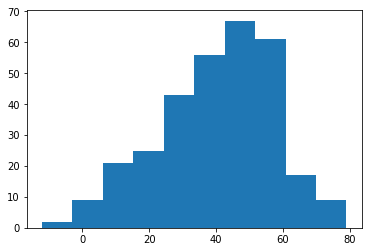

In [12]:
def get_age_distribution(dataset, dummy_batch_size = 128):
    res = []
    
    iterator = Iterator(dataset, batch_size = dummy_batch_size)
    
    for batch in iterator:
        res.append(batch.AGE)
        
    return torch.cat(res)
    
age_dist = get_age_distribution(val)
    
print(age_dist.shape)

plt.hist(age_dist.numpy())

In [13]:
def plot_data(data, ages, sexes, N=10, save=True):
    data = data[:N, :].numpy()
    
    new_data = np.empty(data.shape, dtype = 'object')
    for row, col in itertools.product(range(data.shape[0]), range(data.shape[1])):
        new_data[row, col] = ENDPOINT.vocab.itos[data[row, col]]
    
    cmap = {
        'None': '#ffffff',
    }
    
    fig, ax = plt.subplots(figsize=(8, 5))
    ax = catheat.heatmap(new_data, cmap = cmap, ax = ax, linewidths = .5, leg_pos = 'top')
    
    labels = list(map(lambda x: SEX.vocab.itos[sexes[x]] + ', ' + str(int(ages[x])), range(N)))
    plt.yticks(np.arange(N) + 0.5, labels, rotation = 0)
    
    if save:
        plt.savefig('figs/catheat.svg')
    else:
        plt.show()
            

    
batch = next(iter(val_iter))

data = batch.ENDPOINT.transpose(0, 1)
ages = batch.AGE
sexes = batch.SEX.view(-1)

N = 15

#plot_data(data, ages, sexes, N, False)


In [14]:
'''
iterator = Iterator(val, 5)

batch = next(iter(iterator))

age = batch.AGE
print(age)
ages = age.view(-1, 1).type(Tensor) + torch.arange(3, dtype=torch.float32, device=device)
print(ages)
age = ages[:, 1].view(-1, 1)
print(age)

sex = batch.SEX
print(sex)
sex = (sex.view(-1, 1) - 2).type(Tensor)
print(sex)
print(sex.repeat(1, 3))

test = torch.randn(5, 2).type(Tensor)
print(test)
test = torch.cat([test, age / 100, sex], dim = 1)
print(test)
test.unsqueeze(dim=1).shape
'''


'\niterator = Iterator(val, 5)\n\nbatch = next(iter(iterator))\n\nage = batch.AGE\nprint(age)\nages = age.view(-1, 1).type(Tensor) + torch.arange(3, dtype=torch.float32, device=device)\nprint(ages)\nage = ages[:, 1].view(-1, 1)\nprint(age)\n\nsex = batch.SEX\nprint(sex)\nsex = (sex.view(-1, 1) - 2).type(Tensor)\nprint(sex)\nprint(sex.repeat(1, 3))\n\ntest = torch.randn(5, 2).type(Tensor)\nprint(test)\ntest = torch.cat([test, age / 100, sex], dim = 1)\nprint(test)\ntest.unsqueeze(dim=1).shape\n'

In [140]:
%%time

def get_transition_matrix(data, vocab_size, d = 1, ignore_time = False, eps = 1e-20):
    if ignore_time:
        transition_freq = torch.ones(vocab_size - 3, vocab_size - 3) # no <unk>, <pad>, or None
        
        for v1 in range(3, vocab_size):
            for v2 in range(v1, vocab_size):
                li1 = data == v1
                li2 = data == v2
                
                cumsum1 = torch.cumsum(li1, dim = 1)
                cumsum2 = torch.cumsum(li2, dim = 1)
                
                sum1 = torch.sum(cumsum1 == 0, dim = 1)
                sum2 = torch.sum(cumsum2 == 0, dim = 1)
                
                res1 = (sum1 <= sum2) & (sum2 < data.shape[1])
                res2 = (sum2 <= sum1) & (sum1 < data.shape[1])
                
                transition_freq[v1 - 3, v2 - 3] = res1.float().mean()
                transition_freq[v2 - 3, v1 - 3] = res2.float().mean()
            
    else:
        transition_count = torch.zeros(vocab_size - 2, vocab_size - 2)

        for indv in data:
            for idx in range(len(indv) - d):
                i1 = idx
                i2 = i1 + d
                ep1 = indv[i1]
                ep2 = indv[i2]
                if ep1 > 1 and ep2 > 1:
                    transition_count[ep1 - 2, ep2 - 2] += 1

        #print(torch.sum(transition_count, dim = 1))
        transition_freq = (transition_count.transpose(0, 1) / (torch.sum(transition_count, dim = 1) + eps)).transpose(0, 1)
                    
    return transition_freq
        
iterator = Iterator(train, batch_size = len(train_sequences))

transition_freq = get_transition_matrix(next(iter(iterator)).ENDPOINT.transpose(0, 1), vocab_size, ignore_time = True)    
print(data.shape)
print(data_fake.shape)
#transition_freq = get_transition_matrix(data, vocab_size, ignore_time = True)    
print(transition_freq)
#print(transition_freq.sum(dim = -1))


torch.Size([2789, 18])
torch.Size([2789, 18])
tensor([[0.1362, 0.0237, 0.0183, 0.0050, 0.0050, 0.0011],
        [0.0391, 0.1983, 0.0204, 0.0090, 0.0093, 0.0032],
        [0.0197, 0.0140, 0.0846, 0.0108, 0.0039, 0.0000],
        [0.0158, 0.0115, 0.0068, 0.0463, 0.0018, 0.0004],
        [0.0057, 0.0039, 0.0029, 0.0000, 0.0316, 0.0011],
        [0.0043, 0.0043, 0.0014, 0.0000, 0.0007, 0.0258]])
CPU times: user 76 ms, sys: 4 ms, total: 80 ms
Wall time: 54 ms


In [141]:
%%time

iterator = Iterator(train, batch_size = len(train_sequences))

transition_freq1 = get_transition_matrix(next(iter(iterator)).ENDPOINT.transpose(0, 1), vocab_size, d = 1)    
transition_freq2 = get_transition_matrix(next(iter(val_iter)).ENDPOINT.transpose(0, 1), vocab_size, d = 1)    

print(transition_freq1)
print(transition_freq2)
print((transition_freq1 - transition_freq2).abs().mean())


tensor([[0.9670, 0.0078, 0.0149, 0.0048, 0.0025, 0.0016, 0.0014],
        [0.1729, 0.7183, 0.0558, 0.0351, 0.0076, 0.0083, 0.0021],
        [0.6316, 0.0999, 0.2310, 0.0156, 0.0114, 0.0083, 0.0021],
        [0.6141, 0.1644, 0.0604, 0.1174, 0.0403, 0.0034, 0.0000],
        [0.5934, 0.0989, 0.0824, 0.0275, 0.1868, 0.0110, 0.0000],
        [0.6667, 0.1333, 0.0476, 0.0190, 0.0000, 0.1143, 0.0190],
        [0.8800, 0.0667, 0.0133, 0.0000, 0.0000, 0.0267, 0.0133]])
tensor([[9.6710e-01, 6.7019e-03, 1.7669e-02, 4.4679e-03, 1.6247e-03, 1.6247e-03,
         8.1235e-04],
        [1.4583e-01, 7.1528e-01, 9.0278e-02, 1.3889e-02, 6.9444e-03, 2.0833e-02,
         6.9444e-03],
        [5.8333e-01, 1.0606e-01, 2.6515e-01, 1.5152e-02, 2.2727e-02, 7.5758e-03,
         0.0000e+00],
        [6.8966e-01, 3.4483e-02, 6.8966e-02, 6.8966e-02, 1.3793e-01, 0.0000e+00,
         0.0000e+00],
        [4.7826e-01, 8.6957e-02, 4.3478e-02, 8.6957e-02, 2.6087e-01, 4.3478e-02,
         0.0000e+00],
        [4.6154e-01, 2

In [17]:
subjects = sequences.index
n_individuals = len(subjects)
print(n_individuals)
sequence_length = 2017 - 2000 + 1
print(vocab_size / (n_individuals * sequence_length)) # The lower this is the easier it is for the generator to learn

3099
0.00016134236850596966


In [18]:
# Test generator output

mem_slots = 4
head_size = 2
embed_size = 2
temperature = 1
num_heads = 2

G = RelationalMemoryGenerator(mem_slots, head_size, embed_size, vocab_size, temperature, num_heads)

start_token = torch.tensor([[2]])
memory = G.initial_state(batch_size = 1)

if cuda:
    G.cuda()
    memory = memory.cuda()
    start_token = start_token.cuda()

print(memory)
logits, tokens, memory = G(start_token, torch.tensor([[20]]), torch.tensor([[2]]), memory, sequence_length)
print(logits)
print(tokens)
print(memory)


tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]], device='cuda:0')
tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.]]], device='cuda:0',
       g

In [171]:
%%time

# Define generator evaluation functions

def get_real_and_fake_data(G, dataset, ignore_similar, batch_size, sequence_length, include_age_and_sex = False):
    iterator = Iterator(dataset, batch_size = batch_size)
    
    if cuda:
        G.cuda()
    
    data = []
    data_fake = []
    
    if include_age_and_sex:
        ages = []
        sexes = []
    
    for batch in iterator:
        data_tmp = batch.ENDPOINT.transpose(0, 1)
        data.append(data_tmp)
        
        if include_age_and_sex:
            ages.append(batch.AGE)
            sexes.append(batch.SEX.view(-1))

        start_tokens = data_tmp[:, :1]

        if cuda:
            start_tokens = start_tokens.cuda()

        _, data_fake_tmp, _ = G(start_tokens, batch.AGE, batch.SEX.view(-1), None, sequence_length)
        
        data_fake.append(data_fake_tmp.cpu())
    
    data = torch.cat(data)
    data_fake = torch.cat(data_fake)
    
    if include_age_and_sex:
        ages = torch.cat(ages)
        sexes = torch.cat(sexes)
    
    # Filter those fake samples out which have at least 1 exact match in the real data
    if ignore_similar:
        li = robust_get_similarity_score(data_fake, data, batch_size, True)
        data_fake = data_fake[~li, :]
        
        if include_age_and_sex:
            ages_fake = ages[~li]
            sexes_fake = sexes[~li]
        
            return data, ages, sexes, data_fake, ages_fake, sexes_fake
        
    if include_age_and_sex:
        return data, ages, sexes, data_fake

    return data, data_fake

# More interpretable version of chi_sqrd_dist
def get_diffs(dist, target, separate = False):
    abs_diffs = torch.abs(dist - target)
    
    #max_abs_diffs, _ = torch.stack([torch.ones(target.shape) - target, target], dim = 1).max(dim = 1)
    
    relative_diffs = abs_diffs #/ max_abs_diffs
    
    if separate:
        return relative_diffs
    
    return relative_diffs.mean()

    
def chi_sqrd_dist(counts1, counts2, separate = False, eps = 1e-20):
    counts1 = counts1.view(1, -1)
    counts2 = counts2.view(1, -1)
    table = torch.cat([counts1, counts2], dim = 0)
    col_sums = torch.sum(table, dim = 0)
    row_sums = torch.sum(table, dim = 1)
    n = torch.sum(col_sums)
    
    table_freq = table / (n + eps)
    col_freqs = col_sums / (n + eps)
    row_freqs = row_sums / (n + eps)
    
    diffs = table_freq[0, :] / (row_freqs[0] + eps) - table_freq[1, :] / (row_freqs[1] + eps)
    diffs_sqrd = diffs ** 2
    diffs_sqrd_norm = diffs_sqrd / (col_freqs + eps)
    
    if separate: 
        return diffs_sqrd_norm
    
    chi_sqrd_distance = torch.sum(diffs_sqrd_norm)
    
    return chi_sqrd_distance
    
def get_score(data_fake, ENDPOINT, vocab_size):
    counts_real, freqs_real = get_distribution(None, ENDPOINT, vocab_size, fake = False)
    
    counts_fake, freqs_fake = get_distribution(data_fake, None, vocab_size, fake = True)
    
    #score = chi_sqrd_dist(counts_fake, counts_real)
    score = get_diffs(freqs_fake, freqs_real)
    return score

def get_transition_score(data, data_fake, d, ignore_time, separate, vocab_size):
    transition_freq_real = get_transition_matrix(data, vocab_size, d, ignore_time)
    transition_freq_fake = get_transition_matrix(data_fake, vocab_size, d, ignore_time)
    
    if ignore_time:
        res = (transition_freq_real - transition_freq_fake).abs()
                
        if separate:
            return res
        
        return torch.mean(res, dim = 1)
        
    else:
        chi_sqrd_ds = []
        for i in range(transition_freq_real.shape[0]):
            #chi_sqrd_d = chi_sqrd_dist(transition_count_fake[i, :], transition_count_real[i, :])
            chi_sqrd_d = get_diffs(transition_freq_fake[i, :], transition_freq_real[i, :])
            chi_sqrd_ds.append(chi_sqrd_d)

        chi_sqrd_ds = torch.tensor(chi_sqrd_ds)

        if separate:
            return chi_sqrd_ds

        return torch.mean(chi_sqrd_ds)
    
def get_aggregate_transition_score(data, data_fake, ignore_time, separate1, separate2, vocab_size, sequence_length):
    if ignore_time:
        result = get_transition_score(data, data_fake, None, True, separate1, vocab_size)
    else:
        scores = []
        for d in range(1, sequence_length):
            transition_score = get_transition_score(data, data_fake, d, False, separate1, vocab_size)
            scores.append(transition_score)

        result = torch.stack(scores)

    if separate2:
        return result

    if separate1:
        return torch.mean(result, dim = 0)
    else:
        return torch.mean(result)
    
def get_similarity_score(data1, data2, separate):
    n = data1.shape[0]
    m = data2.shape[0]
    res = torch.zeros(n, m)
    
    for i in range(m):
        res[:, i] = (data1 == data2[i]).all(dim = 1)
        
    res = res.byte().any(dim = 1)
    
    if separate:
        return res
            
    return res.float().mean()

def robust_get_similarity_score(data1, data2, batch_size, separate):
    lis = []
        
    for i in range(0, data1.shape[0], batch_size):
        data1_tmp = data1[i:i+batch_size, :]
        li = get_similarity_score(data1_tmp, data2, True)
        lis.append(li)
        
    res = torch.cat(lis)
    
    if separate:
        return res
            
    return res.float().mean()
    
    
def get_individual_distribution(data, vocab_size, sequence_length):
    individual_counts = torch.zeros(vocab_size - 3, sequence_length + 1)
    
    for v in range(3, vocab_size):
        counts = torch.sum(data == v, dim = 1)
        
        for i in range(sequence_length + 1):
            individual_counts[v - 3, i] += torch.sum(counts == i)
            
    individual_freqs = (individual_counts.transpose(0, 1) / torch.sum(individual_counts, dim = 1)).transpose(0, 1)
    
    return individual_counts, individual_freqs


def get_individual_score(data, data_fake, separate, vocab_size, sequence_length):
    individual_counts_real, individual_freqs_real = get_individual_distribution(data, vocab_size, sequence_length)
    
    individual_counts_fake, individual_freqs_fake = get_individual_distribution(data_fake, vocab_size, sequence_length)
    
    individual_scores = torch.zeros(individual_counts_real.shape[0])
    
    for i in range(individual_counts_real.shape[0]):
        #individual_scores[i] = chi_sqrd_dist(individual_counts_fake[i, :], individual_counts_real[i, :])
        individual_scores[i] = get_diffs(individual_freqs_fake[i, :], individual_freqs_real[i, :])
        
    if separate:
        return individual_scores
    
    return individual_scores.mean()




data, data_fake = get_real_and_fake_data(G, train, True, batch_size, sequence_length)
print(data.shape)

score = get_score(data_fake, ENDPOINT, vocab_size)
print(score)

aggr_transition_score = get_aggregate_transition_score(data, data_fake, True, True, True, vocab_size, sequence_length)
print(aggr_transition_score)

#sim = get_similarity_score(data, data_fake, False)
sim = robust_get_similarity_score(data, data_fake, 256, False)
print(sim)

indv_score = get_individual_score(data, data_fake, True, vocab_size, sequence_length)
print(indv_score)



torch.Size([2789, 18])
tensor(0.2208)
tensor([[0.6784, 0.3299, 0.3471, 0.3223, 0.3352, 0.3209],
        [0.3041, 0.6655, 0.3410, 0.3177, 0.3431, 0.3234],
        [0.3546, 0.4105, 0.8293, 0.3664, 0.4034, 0.3901],
        [0.3055, 0.3478, 0.3503, 0.7601, 0.3299, 0.3478],
        [0.2678, 0.3012, 0.2825, 0.2790, 0.7307, 0.2632],
        [0.4485, 0.4930, 0.4790, 0.4170, 0.4579, 0.9283]])
tensor(0.)
tensor([0.0745, 0.0702, 0.0873, 0.0800, 0.0769, 0.0977])
CPU times: user 11.1 s, sys: 376 ms, total: 11.5 s
Wall time: 6.31 s


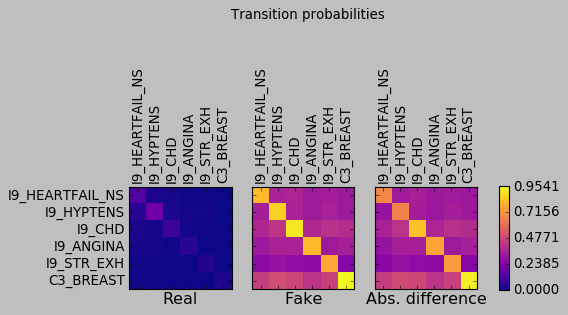

In [172]:
plt.style.use('classic')

def plot_transition_matrix_comparisons(G, dataset, ENDPOINT, batch_size, sequence_length, vocab_size, ignore_time, title):
    #data, data_fake = get_real_and_fake_data(G, dataset, True, batch_size, sequence_length)
    
    transition_freq_real = get_transition_matrix(data, vocab_size, 1, ignore_time)
    transition_freq_fake = get_transition_matrix(data_fake, vocab_size, 1, ignore_time)
    
    fig, ax = plt.subplots(1, 3, sharex='col', sharey='row')
    fig.subplots_adjust(left=0.22075, right=0.9)
    ticks = np.arange(vocab_size - 3)
    labels = [ENDPOINT.vocab.itos[i + 3] for i in ticks]
    cmap = 'plasma'
    
    vmax = torch.max(transition_freq_fake.max(), transition_freq_real.max())
    
    im = ax[0].matshow(transition_freq_real, vmin=0, vmax=vmax, cmap=cmap)
    ax[0].set_xticks(ticks)
    ax[0].set_xticklabels(labels, rotation=90)
    ax[0].set_title('Real', y = -0.2)
    
    ax[1].matshow(transition_freq_fake, vmin=0, vmax=vmax, cmap=cmap)
    ax[1].set_xticks(ticks)
    ax[1].set_xticklabels(labels, rotation=90)
    ax[1].set_title('Fake', y = -0.2)
    
    ax[2].matshow(torch.abs(transition_freq_fake - transition_freq_real), vmin=0, vmax=vmax, cmap=cmap)
    ax[2].set_xticks(ticks)
    ax[2].set_xticklabels(labels, rotation=90)
    ax[2].set_title('Abs. difference', y = -0.2)
    
    plt.yticks(ticks, labels)
    
    fig.colorbar(im, ax=ax.ravel().tolist(), ticks=np.linspace(0, vmax, 5), shrink = 0.27, aspect = 10)
    if title:
        fig.suptitle('Transition probabilities')
    fig.savefig('figs/transition_matrices.svg')

    
plot_transition_matrix_comparisons(G, train, ENDPOINT, 128, sequence_length, vocab_size, ignore_time, True)



REAL:
<lifelines.CoxPHFitter: fitted with 49045 observations, 38264 censored>
      duration col = 'duration'
         event col = 'outcome'
number of subjects = 49045
  number of events = 10781
partial log-likelihood = -114301.88
  time fit was run = 2019-07-25 10:36:47 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
predictor -1.36      0.26      0.10           -1.56           -1.17                0.21                0.31

               z      p  -log2(p)
predictor -13.70 <0.005    139.49
---
Concordance = 0.51
Log-likelihood ratio test = 306.13 on 1 df, -log2(p)=225.28
The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's be

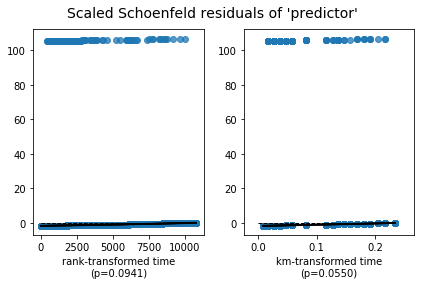

In [58]:
#%%time
from params import *

def get_survival_analysis_input(data, ENDPOINT, event_name, predictor_name, sequence_length):
    event_i = ENDPOINT.vocab.stoi[event_name]
    predictor_i = ENDPOINT.vocab.stoi[predictor_name]
    
    col_idx = torch.arange(sequence_length)
    
    n = data.shape[0]
    start_times = np.zeros((n,))
    end_times = np.zeros((n,))
    
    new_start_times = []
    new_end_times = []
    
    predictors = (data == predictor_i).byte()
    events = (data == event_i).byte()
    
    preds = predictors.any(dim = 1)
    outcomes = events.any(dim = 1)
    
    new_preds = []
    new_outcomes = []
    
    for i in range(n):
        pred = predictors[i, :]
        event = events[i, :]
        
        end_time = sequence_length
        times = col_idx[event]
        if times.shape[0] > 0:
            end_time = times[0]
        
        start_time = 0
        times = col_idx[pred]
        if times.shape[0] > 0:
            start_time = times[0]
            
        if start_time > end_time:
            start_time = 0
            preds[i] = False
            
        if start_time > 0:
            new_start_time = 0
            new_end_time = start_time
            
            new_start_times.append(new_start_time)
            new_end_times.append(new_end_time)
            new_preds.append(False)
            new_outcomes.append(False)
            
        start_times[i] = int(start_time)
        end_times[i] = int(end_time)
        
    start_times = np.concatenate([start_times, new_start_times])
    end_times = np.concatenate([end_times, new_end_times])
    
    start_times = pd.Series(start_times, name='start_time')
    end_times = pd.Series(end_times, name='end_time')
    
    preds = np.concatenate([preds.numpy(), new_preds])
    outcomes = np.concatenate([outcomes.numpy(), new_outcomes])
        
    preds = pd.Series(preds, name='predictor')
    outcomes = pd.Series(outcomes, name='outcome')
    
    res = pd.DataFrame({
        'predictor': preds, 
        'outcome': outcomes,
        'duration': end_times - start_times
    })
    
    return res
    


def analyse(n_rows, event_name, predictor_name):
    #train, val, ENDPOINT, AGE, SEX, vocab_size, sequence_length, n_individuals = get_dataset(nrows = n_rows)
    #print('Data loaded, number of individuals:', n_individuals)
    
    G = RelationalMemoryGenerator(mem_slots, head_size, embed_size, vocab_size, temperature, num_heads, num_blocks)
    G.load_state_dict(torch.load(G_filename))
    G.eval()
    
    #data, data_fake = get_real_and_fake_data(G, train, True, dummy_batch_size, sequence_length)
    
    
    
    print()
    print('REAL:')
    surv_inp = get_survival_analysis_input(data, ENDPOINT, event_name, predictor_name, sequence_length)
    
    cph = CoxPHFitter()
    cph.fit(surv_inp, duration_col='duration', event_col='outcome', show_progress=False)
    cph.print_summary()  # access the results using cph.summary
    cph.check_assumptions(surv_inp, p_value_threshold=0.05, show_plots=True)
    plt.show()
    #cph.plot_covariate_groups('predictor', [0, 1])
    #plt.savefig('figs/test_real.svg')
    
    '''
    print()
    print('FAKE:')
    surv_inp = get_survival_analysis_input(data_fake, ENDPOINT, event_name, predictor_name, sequence_length)

    cph = CoxPHFitter()
    cph.fit(surv_inp, duration_col='duration', event_col='outcome', show_progress=True)
    cph.print_summary()  # access the results using cph.summary
    cph.plot_covariate_groups()
    #plt.savefig('figs/test_fake.svg')
    '''
    
    
n_rows = 30_000_000
event_name = 'I9_CHD'
predictor_name = 'C3_BREAST'
analyse(n_rows, event_name, predictor_name)


In [99]:
# Test Discriminator output

n_embeddings = 2
embed_size = 2
out_channels = 5 
filter_sizes = [2, 3] # values can be at most the sequence_length

D = RelGANDiscriminator(n_embeddings, vocab_size, embed_size, sequence_length, out_channels, filter_sizes)

if cuda:
    D.cuda()

inp = logits
print(inp)
print(D(inp, False))
print(D(inp))


tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.]]], device='cuda:0',
       grad_fn=<CatBackward>)


TypeError: forward() missing 1 required positional argument: 'sex'

In [ ]:
# Define the generator pre-train function

def pretrain_generator(G, train, batch_size, vocab_size, sequence_length, n_epochs, lr, print_step = 10):
    loss_function = nn.BCELoss()
    optimizer = torch.optim.Adam(G.parameters(), lr=lr)
    
    if cuda:
        G.cuda()
        loss_function.cuda()
    
    for e in range(n_epochs):
        train_iter = Iterator(train, batch_size = batch_size, device = device)
        loss_total = 0
        count = 0
        
        for batch in train_iter:
            train_data = batch.ENDPOINT.transpose(0, 1)
            train_data_one_hot = F.one_hot(train_data, vocab_size).type(Tensor)
            
            start_token = train_data[:, :1]
            optimizer.zero_grad()

            memory = G.initial_state(batch_size = train_data.shape[0])

            if cuda:
                start_token = start_token.cuda()
                memory = memory.cuda()
                
            logits, _, _, _ = G(start_token, batch.AGE, batch.SEX, memory, sequence_length, 1.0)

            loss = loss_function(logits, train_data_one_hot)
            
            loss_total += loss.item()
            count += 1

            loss.backward()
            optimizer.step()
            
        
        if e % print_step == 0:
            print(
                "[Epoch %d/%d] [G loss: %f]"
                % (e, n_epochs, loss_total / count)
            )

In [19]:
mem_slots = 4
head_size = 2
embed_size = 2
temperature = 1
num_heads = 2

G = RelationalMemoryGenerator(mem_slots, head_size, embed_size, vocab_size, temperature, num_heads)
    
score = get_score(G, ENDPOINT, val)
print(score)
aggr_transition_score = get_aggregate_transition_score(G, val, 64, True, True)
print(aggr_transition_score)
print(aggr_transition_score.mean())

batch_size = 64
pretrain_generator(G, train, batch_size, vocab_size, sequence_length, 2, 0.01, print_step = 1)

score = get_score(G, ENDPOINT, val)
print(score)
aggr_transition_score = get_aggregate_transition_score(G, val, 64, True, True)
print(aggr_transition_score)
print(aggr_transition_score.mean())

tensor(0.3332)
tensor([[3.1501, 0.4413, 2.4795, 0.8596, 0.3531, 1.3549],
        [1.5915, 0.5093, 2.7898, 0.6782, 0.1614, 1.4908],
        [1.0000, 0.5874, 1.9401, 0.3692, 0.3916, 1.9036],
        [0.0000, 0.4176, 1.6537, 0.7870, 0.9444, 1.3333]])
tensor(1.1328)
[Epoch 0/2] [G loss: 4.915725]
[Epoch 1/2] [G loss: 4.633242]
tensor(0.0546)
tensor([[1.5259, 0.6375, 1.6095, 0.6953, 0.8018, 2.0506],
        [1.9493, 0.7160, 0.6719, 1.3088, 1.3030, 1.5187],
        [1.0000, 0.7887, 0.9804, 1.3968, 0.6902, 0.2657],
        [0.0000, 0.4144, 0.8132, 0.1709, 0.7333, 1.5556]])
tensor(0.9832)


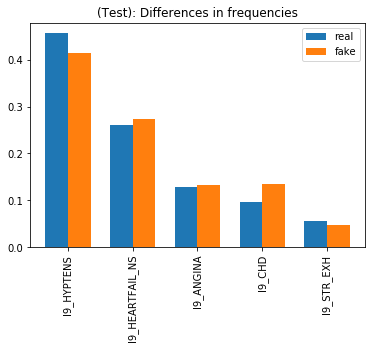

In [20]:
def save_grouped_barplot(freqs, freqs_fake, idx, title, N=10):
    freqs1 = freqs.numpy()[idx]
    freqs2 = freqs_fake.numpy()[idx]

    fig, ax = plt.subplots(figsize=(6,6))

    ind = np.arange(N)    # the x locations for the groups
    width = 0.35         # the width of the bars
    p1 = ax.bar(ind, freqs1, width, bottom=0)

    p2 = ax.bar(ind + width, freqs2, width, bottom=0)

    ax.set_title(title)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(map(lambda x: ENDPOINT.vocab.itos[x], idx + 2), rotation=90)

    ax.legend((p1[0], p2[0]), ('real', 'fake'))
    ax.autoscale_view()
    
    fig.subplots_adjust(bottom=0.36)
    fig.savefig('figs/' + '_'.join(title.split(' ')).translate({ord(i): None for i in ':()'}) + '.svg')
    
def save_relative_and_absolute(freqs, freqs_fake, counts, counts_fake, vocab_size, prefix='', N_max=10):
    N = min(N_max, vocab_size - 2)
    if not prefix == '':
        prefix += ' '
    
    if N == vocab_size - 2:
        idx = np.arange(N)
        
        title = prefix + 'Differences in frequencies'
        save_grouped_barplot(freqs, freqs_fake, idx, title, N)
    else:
        abs_diffs = np.abs(freqs - freqs_fake)
        idx = np.argsort(abs_diffs)[-N:]
        idx = np.flip(idx)
        
        title = prefix + 'Largest absolute differences in frequencies'
        save_grouped_barplot(freqs, freqs_fake, idx, title, N)

        chi_sqrd_dists = chi_sqrd_dist(counts, counts_fake, separate = True)
        idx = np.argsort(chi_sqrd_dists)[-N:]
        idx = np.flip(idx)

        title = prefix + 'Largest relative differences in frequencies'
        save_grouped_barplot(freqs, freqs_fake, idx, title, N)
    
counts, freqs = get_distribution(None, ENDPOINT, vocab_size, fake = False)
counts_fake1, _ = get_fake_distribution(G, val)
counts_fake2, _ = get_fake_distribution(G, train)

counts_fake = counts_fake1 + counts_fake2
freqs_fake = counts_fake / torch.sum(counts_fake)

N_max = 10
prefix = '(Test):'

save_relative_and_absolute(freqs, freqs_fake, counts, counts_fake, vocab_size, prefix, N_max)

In [21]:
# Define the training function

def get_scores(G, ENDPOINT, dataset, batch_size = 128, separate1 = True, separate2 = True, \
               vocab_size = vocab_size, sequence_length = sequence_length):
    start_tokens = next(iter(iterator)).ENDPOINT.transpose(0, 1)[:, :1]
    
    score1 = get_score(G, ENDPOINT, dataset, batch_size, vocab_size, sequence_length)
    
    score2 = get_aggregate_transition_score(G, dataset, batch_size, separate1, separate2, vocab_size, sequence_length)
    
    return score1, score2.mean(), score2

def train_GAN(G, D, train, val_iter, batch_size, vocab_size, sequence_length, \
              n_epochs, lr, temperature, print_step = 10, score_fn = get_scores):    
    scores = []
    accuracies_real = []
    accuracies_fake = []
    
    score = score_fn(G, ENDPOINT, val)
    print('Scores before training:', *score)
    scores.append(score)
    
    print('pretraining generator...')
    pretrain_generator(G, train, batch_size, vocab_size, sequence_length, max(n_epochs // 10, 1), \
                       lr * 100, print_step = max(n_epochs // 10 - 1, 1))
    print('pretraining complete')
    
    score = score_fn(G, ENDPOINT, val)
    print("[Scores:", *score, "]")
    scores.append(score)
    
    adversarial_loss = torch.nn.BCELoss()
    
    optimizer_G = torch.optim.Adam(G.parameters(), lr=lr)
    optimizer_D = torch.optim.Adam(D.parameters(), lr=lr)
    
    if cuda:
        G.cuda()
        D.cuda()
        adversarial_loss.cuda()
    
    for e in range(n_epochs):
        train_iter = Iterator(train, batch_size = batch_size, device = device)
        #loss_total = 0
        #count = 0
        
        for batch in train_iter:
            train_data = batch.ENDPOINT.transpose(0, 1)
            train_data_one_hot = F.one_hot(train_data, vocab_size).type(Tensor)

            start_token = train_data[:, :1]
            
            # Adversarial ground truths
            valid = Variable(Tensor(train_data.shape[0]).fill_(1.0), requires_grad=False)
            fake = Variable(Tensor(train_data.shape[0]).fill_(0.0), requires_grad=False)

            optimizer_G.zero_grad()

            # Generate a batch of images
            memory = G.initial_state(batch_size = train_data.shape[0])
            if cuda:
                memory = memory.cuda()

            temp = temperature ** ((e + 1) / n_epochs)
            fake_one_hot, _, _, _ = G(start_token, batch.AGE, batch.SEX, memory, sequence_length, temp)

            # Loss measures generator's ability to fool the discriminator
            g_loss = adversarial_loss(D(fake_one_hot).view(-1), valid)

            g_loss.backward()
            optimizer_G.step()

            optimizer_D.zero_grad()

            # Measure discriminator's ability to classify real from generated samples
            D_out_real = D(train_data_one_hot, batch.AGE, batch.SEX).view(-1)
            D_out_fake = D(fake_one_hot.detach(), batch.AGE, batch.SEX).view(-1)
            
            #print(D_out_real)
            #print(torch.round(D_out_real))
            accuracy_real = torch.mean(D_out_real)
            accuracy_fake = torch.mean(1 - D_out_fake)
            
            real_loss = adversarial_loss(D_out_real, valid)
            fake_loss = adversarial_loss(D_out_fake, fake)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

        if e % print_step == 0:
            print()
            print(
                "[Epoch %d/%d] [D loss: %f] [G loss: %f] [Acc real: %f] [Acc fake: %f]"
                % (e, n_epochs, d_loss.item(), g_loss.item(), accuracy_real, accuracy_fake)
            )
            score = score_fn(G, ENDPOINT, val)
            print("[Scores:", *score, "]")
            scores.append(score)
            accuracies_real.append(accuracy_real)
            accuracies_fake.append(accuracy_fake)
            
    score = score_fn(G, ENDPOINT, val)
    print('Scores after training:', *score)
    scores.append(score)
            
    output = [[] for _ in range(len(scores[0]))]
    for i in range(len(scores)):
        for j in range(len(scores[i])):
            output[j].append(scores[i][j])

    output.append(accuracies_real)
    output.append(accuracies_fake)
            
    for j in range(len(output)):
        output[j] = torch.stack(output[j])
            
    return tuple(output)


Scores before training: tensor(0.2726) tensor(1.1840) tensor([[3.0244, 0.8414, 1.6349, 0.4987, 0.1370, 1.2153],
        [3.7533, 0.9779, 1.7311, 0.2570, 0.3719, 2.2427],
        [1.0000, 0.8103, 2.5675, 0.4588, 0.2826, 1.6522],
        [0.0000, 0.8973, 1.4231, 1.5975, 0.4178, 0.6222]])
pretraining generator...
[Epoch 0/1] [G loss: 5.155181]
pretraining complete
[Scores: tensor(0.0715) tensor(0.9057) tensor([[2.0225, 0.6427, 2.0135, 1.0919, 0.6902, 1.6986],
        [1.8838, 0.6349, 1.0855, 0.9809, 0.5119, 2.1260],
        [1.0000, 0.5005, 0.9091, 0.2051, 0.3949, 0.7101],
        [0.0000, 0.3728, 0.4381, 0.2611, 0.8127, 0.7500]]) ]

[Epoch 0/10] [D loss: 0.693741] [G loss: 0.715832] [Acc real: 0.488462] [Acc fake: 0.511211]
[Scores: tensor(0.0272) tensor(1.1094) tensor([[2.3070, 0.7637, 1.1841, 0.7107, 0.6555, 2.6219],
        [2.1533, 0.4617, 1.0755, 0.5078, 0.8488, 2.1984],
        [1.0000, 0.4847, 1.9431, 0.7494, 1.4773, 1.8519],
        [0.0000, 0.3159, 0.7136, 0.1235, 1.1562, 1.3220

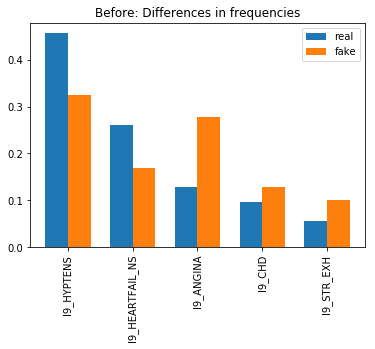

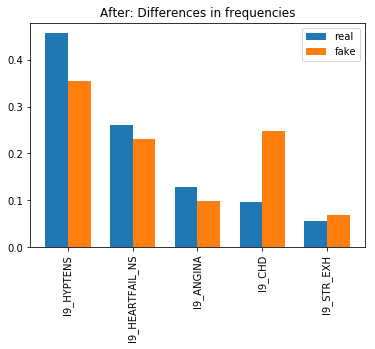

In [24]:
# Train the GAN

start_time = time.time()

# Generator params
mem_slots = 1
head_size = 6
embed_size = 10
temperature = 5
num_heads = 10
num_blocks = 6

G = RelationalMemoryGenerator(mem_slots, head_size, embed_size, vocab_size, temperature, num_heads, num_blocks)

# Discriminator params
n_embeddings = 5
embed_size = embed_size
out_channels = 15
filter_sizes = [2, 3, 4] # values can be at most the sequence_length

D = RelGANDiscriminator(n_embeddings, vocab_size, embed_size, sequence_length, out_channels, filter_sizes)

counts_fake1, _ = get_fake_distribution(G, val)
counts_fake2, _ = get_fake_distribution(G, train)

counts_fake = counts_fake1 + counts_fake2
freqs_fake = counts_fake / torch.sum(counts_fake)

N_max = 10
prefix = 'Before:'

save_relative_and_absolute(freqs, freqs_fake, counts, counts_fake, vocab_size, prefix, N_max)



batch_size = 64
n_epochs = 10
print_step = max(n_epochs // 10, 1)
lr = 1e-4

# Train the GAN
scores1, scores2, scores3, accuracies_real, accuracies_fake = train_GAN(
    G, D, train, val_iter, batch_size, vocab_size, sequence_length, n_epochs, lr, temperature, print_step
)



counts_fake1, _ = get_fake_distribution(G, val)
counts_fake2, _ = get_fake_distribution(G, train)

counts_fake = counts_fake1 + counts_fake2
freqs_fake = counts_fake / torch.sum(counts_fake)

prefix = 'After:'

save_relative_and_absolute(freqs, freqs_fake, counts, counts_fake, vocab_size, prefix, N_max)

print('Time taken:', round_to_n(time.time() - start_time, n = 3), 'seconds')


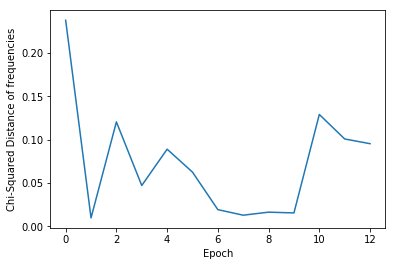

In [30]:
%matplotlib inline

plt.plot(range(scores1.shape[0]), scores1.numpy())
plt.ylabel('Chi-Squared Distance of frequencies')
plt.xlabel('Epoch')
plt.savefig('figs/chisqrd_freqs.svg')

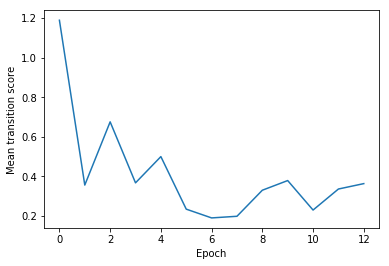

In [31]:
plt.plot(range(scores2.shape[0]), scores2.numpy())
plt.ylabel('Mean transition score')
plt.xlabel('Epoch')
plt.savefig('figs/mean_transition_score.svg')

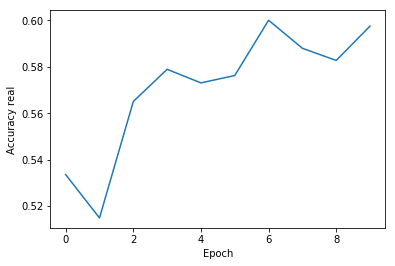

In [32]:
plt.plot(range(accuracies_real.shape[0]), accuracies_real.detach().cpu().numpy())
plt.ylabel('Accuracy real')
plt.xlabel('Epoch')
plt.savefig('figs/accuracy_real.svg')

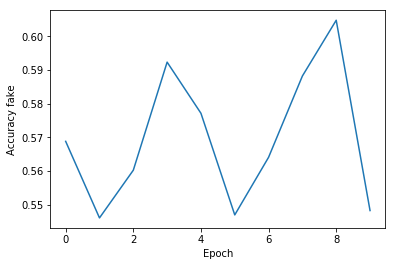

In [33]:
plt.plot(range(accuracies_fake.shape[0]), accuracies_fake.detach().cpu().numpy())
plt.ylabel('Accuracy fake')
plt.xlabel('Epoch')
plt.savefig('figs/accuracy_fake.svg')

In [34]:
for d in range(1, sequence_length):
    plt.plot(range(scores3.shape[0]), scores3[:, d - 1, :].numpy())
    plt.ylabel('Transition score')
    plt.xlabel('Epoch')
    title = 'd=' + str(d)
    plt.title(title)
    labels = [ENDPOINT.vocab.itos[i] for i in range(1, vocab_size)]
    plt.legend(labels)
    plt.savefig('figs/' + title + '.svg')
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [35]:
for v in range(1, vocab_size):
    plt.plot(range(scores3.shape[0]), scores3[:, :, v - 1].numpy())
    plt.ylabel('Transition score')
    plt.xlabel('Epoch')
    title = 'enpoint=' + ENDPOINT.vocab.itos[v]
    plt.title(title)
    labels = ['d=' + str(i) for i in range(1, sequence_length)]
    plt.legend(labels)
    plt.savefig('figs/' + title + '.svg')
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [36]:
test_size = 10
start_tokens = torch.randint(2, vocab_size, (test_size, 1))
print(start_tokens)

memory = G.initial_state(batch_size = test_size)

if cuda:
    memory = memory.cuda()
    start_tokens = start_tokens.cuda()
    
_, data_fake, _, _ = G(start_tokens, batch.AGE, batch.SEX, memory, sequence_length)

data_fake

tensor([[4],
        [4],
        [3],
        [3],
        [4],
        [6],
        [5],
        [3],
        [2],
        [3]])


tensor([[4, 4, 5, 5, 3],
        [4, 4, 4, 4, 4],
        [3, 3, 3, 3, 3],
        [3, 3, 3, 3, 3],
        [4, 2, 1, 1, 1],
        [6, 6, 6, 6, 6],
        [5, 5, 3, 3, 3],
        [3, 3, 3, 3, 3],
        [2, 2, 2, 2, 3],
        [3, 3, 3, 3, 3]], device='cuda:0')